In [132]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from tqdm import tqdm
from torch import nn
from sklearn.metrics import accuracy_score

In [133]:
from cassava.transforms import get_test_transforms

In [134]:
%matplotlib inline

In [135]:
metrics = context.catalog.load('train_metrics')

2020-12-04 23:37:20,608 - kedro.io.data_catalog - INFO - Loading data from `train_metrics` (PickleDataSet)...


In [136]:
metrics['last_epoch']

7

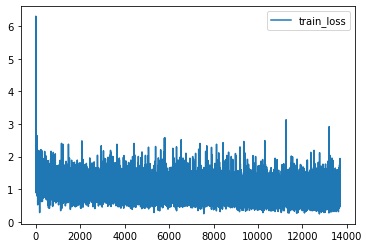

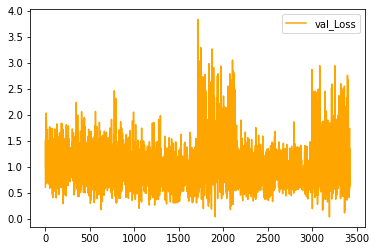

In [137]:
plt.figure()
sns.lineplot(data=metrics['train_losses'], label='train_loss')
plt.show()

plt.figure()
sns.lineplot(data=metrics['validation_losses'], label='val_Loss', color='orange')
plt.show()

In [138]:
val_scores = context.catalog.load('val_scores')
val_scores

2020-12-04 23:37:21,948 - kedro.io.data_catalog - INFO - Loading data from `val_scores` (PickleDataSet)...


/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'accuracy': 0.6619158878504673,
 'confusion_matrix': array([[  39,   37,    3,    3,   32],
        [  17,   71,   12,    4,   10],
        [   1,    7,   14,    5,   14],
        [ 126,  276,  411, 2606,  357],
        [  34,   47,   37,   14,  103]]),
 'f1_score': 0.7462869204127027}

In [139]:
#!curl https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py -O cf_matrix.py

In [140]:
from cf_matrix import make_confusion_matrix

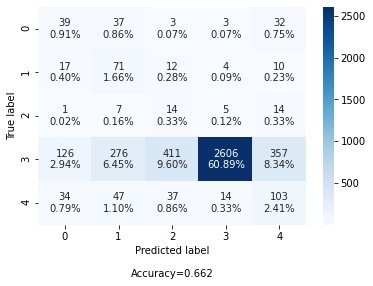

In [141]:
make_confusion_matrix(val_scores['confusion_matrix'])

In [142]:
model = context.catalog.load('model')

2020-12-04 23:37:22,423 - kedro.io.data_catalog - INFO - Loading data from `model` (TorchLocalModel)...


Using cache found in /home/boris/.cache/torch/hub/pytorch_vision_v0.6.0


In [143]:
model.eval()

ResnetModel(
  (trunk): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [144]:
def plot_image(img, label=None, ax=None):
    if not ax:
        ax = plt.gca()
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')
    if label is not None:
        
        if isinstance(label, int):
            label = label_num_to_disease_map.get(label, 0)
        ax.set_title(f'L: {label}')

In [170]:
train_images_torch = context.catalog.load('train_images_torch')

2020-12-04 23:43:04,101 - kedro.io.data_catalog - INFO - Loading data from `train_images_torch` (ImageFolderDataSet)...


In [171]:
train_images_torch.transform = get_test_transforms()

In [172]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unnorm = UnNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Predict on random image

In [173]:
nn.functional.softmax(torch.Tensor([[5, 100], [5, 100]]), dim=0)

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]])

In [174]:
train_images_torch.transform = get_test_transforms()

In [175]:
def predict(model, x, invtemp=1):
    logits = model.forward(x)
    probabilities = nn.functional.softmax(invtemp*logits, dim=1)
    return probabilities

def pred_label(model, x, invtemp=1):
    return torch.max(predict(model, x, invtemp=invtemp), 1)[1]

def predict_diff_temps(model, x, invtemps):
    logits = model.forward(x)
    
    return {
        temp: nn.functional.softmax(temp*logits, dim=1) for temp in invtemps
    }


/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


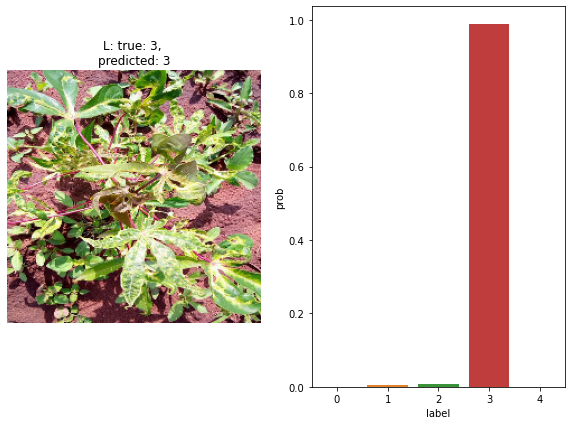

In [188]:
random_idx = np.random.choice(range(len(train_images_torch)))
image, label = train_images_torch[random_idx]

probabilities = predict(model, image.unsqueeze(0), invtemp=0.5)[0]
prediction = pred_label(model, image.unsqueeze(0)).item()

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plot_image(unnorm(image), label=f"true: {label}, \npredicted: {prediction}")
plt.subplot(1, 2, 2)
sns.barplot(y=probabilities.detach().numpy(), x=list(range(5)))
plt.xlabel('label')
plt.ylabel('prob')
plt.show()

# Calibration curves

In [152]:
from sklearn.calibration import calibration_curve

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [153]:
from cassava.extras.datasets.image_dataset import DatasetFromSubset
import torch

In [154]:
indices = np.random.choice(range(len(train_images_torch)), 2000)

In [155]:
train_images_torch.transform = None

In [156]:
dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=indices),
                      transform=get_test_transforms())
loader = torch.utils.data.DataLoader(dataset, batch_size=10)

In [157]:
predictions = {}
true_labels = []

invtemps = [0.5, 1, 5, 10, 100]

for temp in invtemps:
    predictions[temp] = []

model.eval()
for images, labels in tqdm(loader):
    preds =  predict_diff_temps(model, images, invtemps)
    for temp in invtemps:
        predictions[temp] += preds[temp].tolist()
    true_labels += labels.tolist()

100%|██████████| 200/200 [01:18<00:00,  2.55it/s]


In [158]:
for temp in invtemps:
    predictions[temp] = np.array(predictions[temp])
true_labels = np.array(true_labels)

In [159]:
true_labels[:10]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [160]:
predictions[1][:10]

array([[2.64544701e-06, 1.07969958e-04, 1.13350921e-04, 9.99771059e-01,
        5.03318643e-06],
       [6.50641095e-06, 3.41606734e-04, 3.35415214e-04, 9.99303818e-01,
        1.25926827e-05],
       [4.20679098e-05, 4.22993937e-04, 4.27405396e-03, 9.94876683e-01,
        3.84255458e-04],
       [1.25639495e-02, 1.30762145e-01, 3.71497609e-02, 8.00763190e-01,
        1.87609214e-02],
       [2.49350433e-06, 1.85801146e-05, 3.21386236e-04, 9.99638319e-01,
        1.91830786e-05],
       [3.14583554e-06, 2.59632332e-04, 4.78367183e-05, 9.99687910e-01,
        1.49100424e-06],
       [5.34546841e-03, 8.03919788e-03, 1.07540553e-02, 9.67190087e-01,
        8.67117941e-03],
       [8.72519922e-06, 1.86756442e-04, 9.61520011e-04, 9.98785317e-01,
        5.77959909e-05],
       [2.54983916e-05, 2.26152537e-04, 3.53272888e-04, 9.99354184e-01,
        4.08729611e-05],
       [1.65349538e-05, 4.12958965e-04, 7.81191222e-04, 9.98735845e-01,
        5.34377250e-05]])

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-165-dc36d989ea84>:11: UserWarning: Attempting to set identical bottom == top == 0.68 results in singular transformations; automatically expanding.
  plt.ylim(min(accuracies), max(accuracies))


[0.68, 0.68, 0.68, 0.68, 0.68]


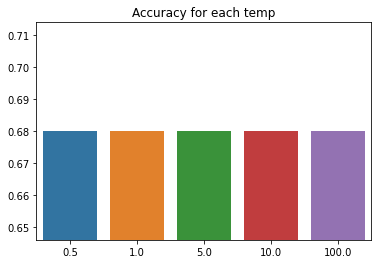

In [165]:
accuracies = []
for temp in invtemps:
    pred_probs = predictions[temp]
    pred_labels = np.argmax(pred_probs, 1)
    
    accuracies.append(accuracy_score(true_labels, pred_labels))
print(accuracies)
plt.figure()
sns.barplot(x=invtemps, y=accuracies)
plt.title('Accuracy for each temp')
plt.ylim(min(accuracies), max(accuracies))
plt.show()

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


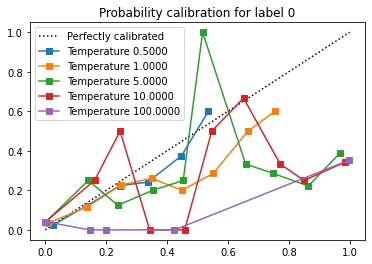

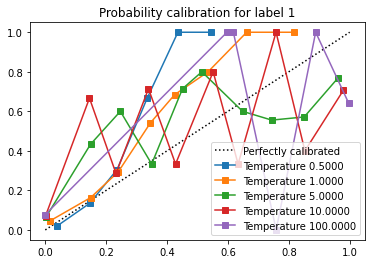

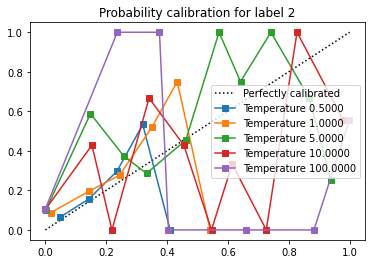

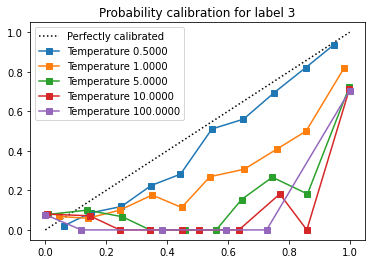

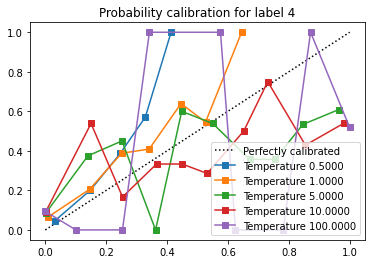

In [166]:
for label in [0, 1, 2, 3, 4]:
    plt.figure()
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.title(f'Probability calibration for label {label}')
    true_label = (true_labels == label)
    
    for temp in invtemps:
        pred_prob = predictions[temp][:, label]
    
        fraction_of_positives, mean_predicted_value = \
                calibration_curve(true_label, pred_prob, n_bins=10)

        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"Temperature {temp:0.4f}")
    plt.legend()
    plt.show()